## Introduction
In this exercise you'll identify an initial set of features in the Ames dataset to develop using mutual information scores and interaction plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

In [2]:
# Load data
df = pd.read_csv("ames.csv")

To start, let's review the meaning of mutual information by looking at a few features from the *Ames* dataset.

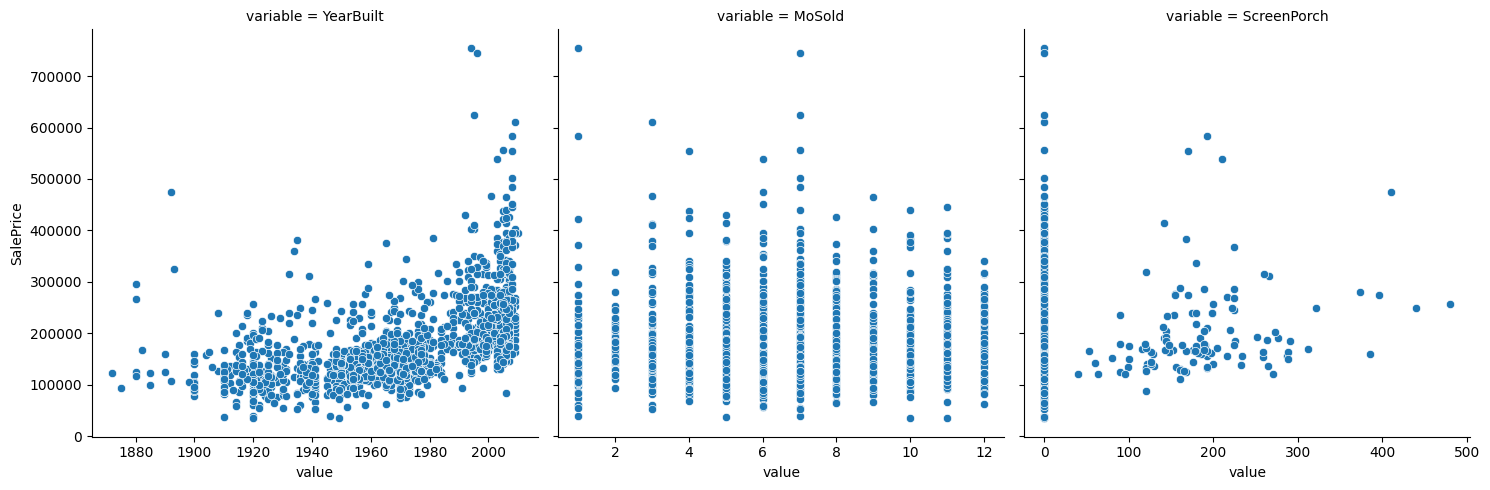

In [3]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

In [21]:
df.shape

(1460, 81)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [23]:
df.dtypes.value_counts()

object     43
int64      35
float64     3
Name: count, dtype: int64

In [36]:
df.fillna(0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,0,Reg,Lvl,AllPub,...,0,0,MnPrv,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,0,Reg,Lvl,AllPub,...,0,0,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,Normal,142125


In [41]:
print(df.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [42]:
df.isna().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 81, dtype: bool

## 1) Understand Mutual Information

Based on the plots, which feature do you think would have the highest mutual information with SalePrice?

Based on the plots, YearBuilt should have the highest MI score since knowing the year tends to constrain SalePrice to a smaller range of possible values. This is generally not the case for MoSold, however. Finally, since ScreenPorch is usually just one value, 0, on average it won't tell you much about SalePrice (though more than MoSold) .

The Ames dataset has seventy-eight features -- a lot to work with all at once! Fortunately, you can identify the features with the most potential.

Use the make_mi_scores function (introduced in the tutorial) to compute mutual information scores for the Ames features:

In [59]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object","float"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    discrete_features=[False]*len(discrete_features)
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [60]:
X = df.copy()
y = X.pop('SalePrice')

In [61]:
mi_scores = make_mi_scores(X, y)

In [62]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

OverallQual     0.562351
Neighborhood    0.494272
GrLivArea       0.484079
YearBuilt       0.370343
GarageCars      0.368134
TotalBsmtSF     0.366474
GarageArea      0.362922
KitchenQual     0.333339
ExterQual       0.327906
BsmtQual        0.320660
1stFlrSF        0.311303
FullBath        0.280077
GarageFinish    0.270657
MSSubClass      0.268300
YearRemodAdd    0.249713
TotRmsAbvGrd    0.223299
GarageType      0.205604
FireplaceQu     0.205559
2ndFlrSF        0.199054
Foundation      0.191480
Name: MI Scores, dtype: float64


In [64]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

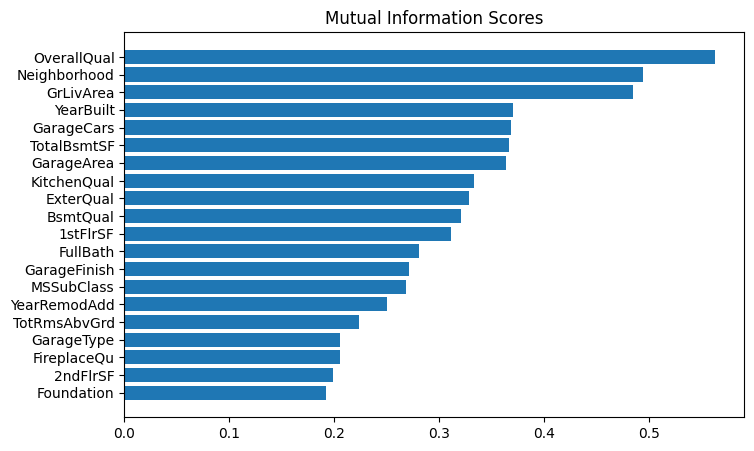

In [65]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

## 2) Examine MI Scores
Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe?

Some common themes among most of these features are:

- Location: Neighborhood
- Size: all of the Area and SF features, and counts like FullBath and GarageCars
- Quality: all of the Qual features
- Year: YearBuilt and YearRemodAdd
- Types: descriptions of features and styles like Foundation and GarageType

These are all the kinds of features you'll commonly see in real-estate listings (like on Zillow), It's good then that our mutual information metric scored them highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant to the average home buyer.

In this step you'll investigate possible interaction effects for the BldgType feature. This feature describes the broad structure of the dwelling in five categories:

Bldg Type (Nominal): Type of dwelling

  - 1Fam    Single-family Detached    
  - 2FmCon    Two-family Conversion; originally built as one-family dwelling
  - Duplx    Duplex
  - TwnhsE    Townhouse End Unit
  - TwnhsI    Townhouse Inside Unit


The BldgType feature didn't get a very high MI score. A plot confirms that the categories in BldgType don't do a good job of distinguishing values in SalePrice (the distributions look fairly similar, in other words):

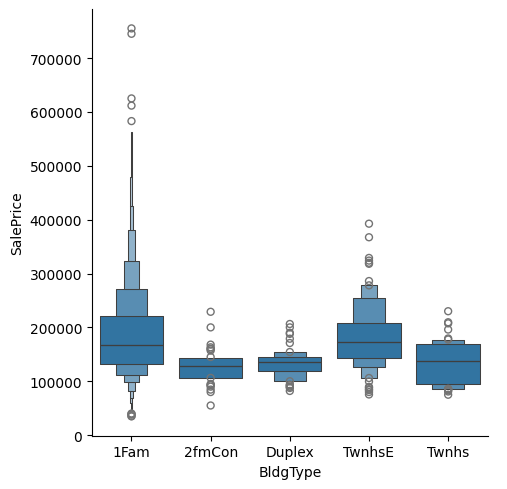

In [66]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. Investigate whether BldgType produces a significant interaction with either of the following:

GrLivArea  # Above ground living area

MoSold     # Month sold

Run the following cell twice, the first time with feature = "GrLivArea" and the next time with feature="MoSold":

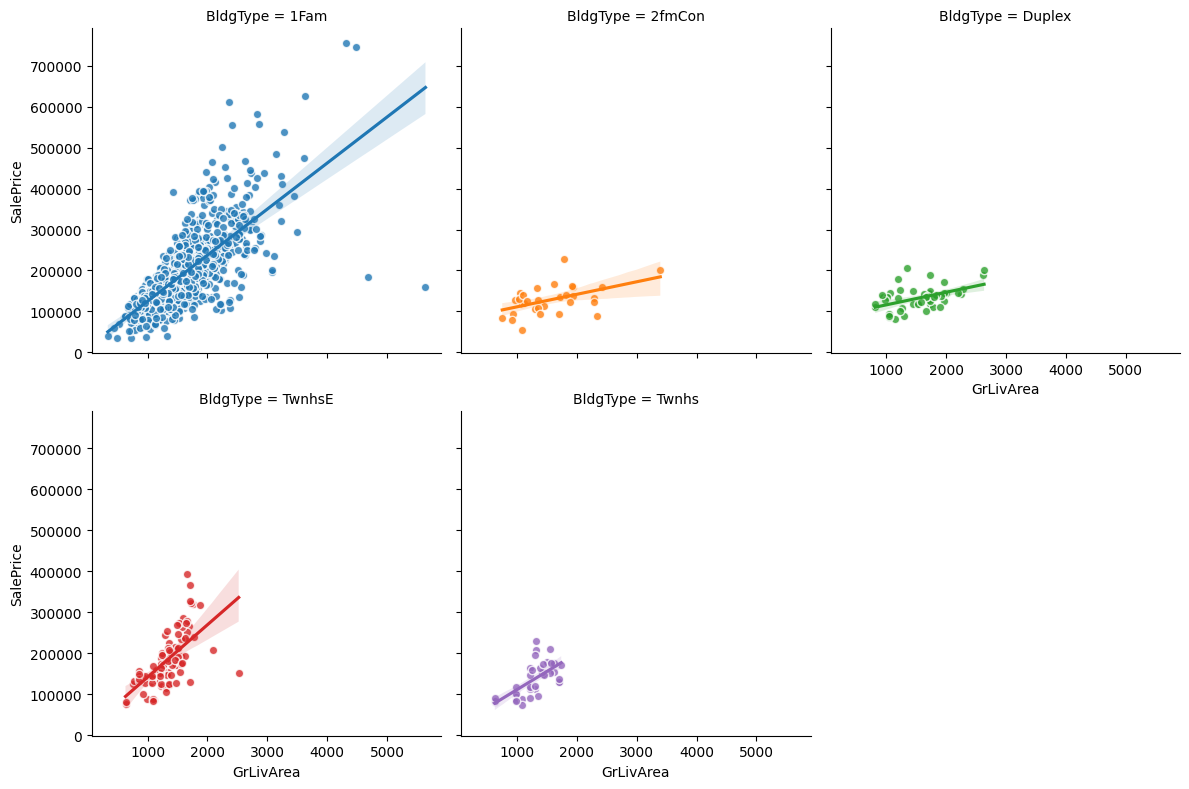

In [67]:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect.

## 3) Discover Interactions
From the plots, does BldgType seem to exhibit an interaction effect with either GrLivArea or MoSold?

The trends lines within each category of BldgType are clearly very different, indicating an interaction between these features. Since knowing BldgType tells us more about how GrLivArea relates to SalePrice, we should consider including BldgType in our feature set.

The trend lines for MoSold, however, are almost all the same. This feature hasn't become more informative for knowing BldgType.

## A First Set of Development Features

Let's take a moment to make a list of features we might focus on. In the exercise in Lesson 3, you'll start to build up a more informative feature set through combinations of the original features you identified as having high potential.

You found that the ten features with the highest MI scores were:

In [68]:
mi_scores.head(10)

OverallQual     0.562351
Neighborhood    0.494272
GrLivArea       0.484079
YearBuilt       0.370343
GarageCars      0.368134
TotalBsmtSF     0.366474
GarageArea      0.362922
KitchenQual     0.333339
ExterQual       0.327906
BsmtQual        0.320660
Name: MI Scores, dtype: float64